In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm, BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool, global_add_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
import random
from statistics import mean

In [2]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [6]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Make cuts on data
def train_make_cuts(train_df, test_df):
    
    train_cut_df_sig = train_df[(train_df['IsB'] == 1) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] > 0.6)]
    train_cut_df_bkg = train_df[(train_df['IsB'] == 0) & (train_df['Jet0_MC_Match'] == 1) & (train_df['Jet0_MC_Jet_EfB'] < 0.6) & (train_df['Jet0_MC_Jet_EfD'] < 0.6)]

    test_cut_df_sig = test_df[(test_df['IsB'] == 1) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] > 0.6)]
    test_cut_df_bkg = test_df[(test_df['IsB'] == 0) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] < 0.6) & (test_df['Jet1_MC_Jet_EfD'] < 0.6)]
    
    train_cut_df = pd.concat([train_cut_df_sig, train_cut_df_bkg], ignore_index=True)
    test_cut_df = pd.concat([test_cut_df_sig, test_cut_df_bkg], ignore_index=True)
    return train_cut_df, test_cut_df

# Calculate Delta R
def deltaR(df, eta_col, phi_col):
    df['DeltaR'] = None 

    for i, row in df.iterrows():
        eta1 = df.loc[i, eta_col]
        eta2 = df.loc[(i+1), eta_col]
        phi1 = df.loc[i, phi_col]
        phi2 = df.loc[(i+1), phi_col]
        deltaR = np.sqrt((eta2 - eta1) ** 2 + (phi2 - phi1) ** 2)
        df.at[i, 'DeltaR'] = deltaR

# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

Data preprocessing

In [8]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT']  #, 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2'] later add DeltaR
test_jet_cols = ['Jet1_Eta', 'Jet1_PT'] #, 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2'] later add DeltaR

# Features columns (daughter kinematics + jet inputs)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Make cuts to data
train_df, test_df = train_make_cuts(train_df, test_df)

# Duplicate single features for each node
train_df = duplicate(train_df, train_jet_cols, 'Jet0_nDaughters')
test_df = duplicate(test_df, test_jet_cols, 'Jet1_nDaughters')

# Convert strings into float lists
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [9]:
full_train_df = train_df
full_test_df = test_df

In [28]:
# Cut out some data for quicker runs
cut_train_df = full_train_df.head(100000) 
cut_test_df = full_test_df.head(100000)

In [30]:
# Pick which size data to feed into model
train_df = cut_train_df
test_df = cut_test_df

In [31]:
training_data = train_df[train_f_cols]

In [32]:
training_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackZ,Jet0_Daughters_trackVX,Jet0_Daughters_trackVY,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT
0,"[14701.412109375, 3931.55810546875, 507.791564...","[2197.087646484375, 616.10302734375, 86.695602...","[211.0, -211.0, 22.0, 22.0, 22.0, 22.0, -211.0...","[122.22395324707031, 110.11969757080078, 22.38...","[2193.685302734375, 606.1820068359375, 83.7559...","[14535.640625, 3880.47509765625, 500.336029052...","[2.5882816314697266, 2.539689064025879, 2.4534...","[1.5151375532150269, 1.3910949230194092, 1.309...","[1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0...","[-0.02419770136475563, -0.0415538065135479, -1...",...,"[63.08610153198242, 63.00299835205078, -1000.0...","[122.22395324707031, 110.11969757080078, -1000...","[2193.685302734375, 606.1820068359375, -1000.0...","[14535.640625, 3880.47509765625, -1000.0, -100...","[-1000.0, -1000.0, 507.79156494140625, 4798.20...","[-1000.0, -1000.0, 3.808302402496338, 0.171235...","[-1000.0, -1000.0, 0.9342803359031677, 0.97503...","[-1000.0, -1000.0, 9.050968170166016, 18.37620...","[2.2525952267162817, 2.2525952267162817, 2.252...","[14758.276454448724, 14758.276454448724, 14758..."
1,"[1689.5546875, 4534.81787109375, 2675.23999023...","[176.82757568359375, 618.9315185546875, 471.14...","[211.0, 22.0, 22.0, -22.0, 211.0, -211.0, 2212...","[-7.498524188995361, 80.52355194091797, -147.9...","[-176.6685028076172, -613.6710815429688, -447....","[1674.46923828125, 4492.38232421875, 2633.4255...","[2.944000005722046, 2.6800029277801514, 2.4219...","[-1.6132148504257202, -1.4403256177902222, -1....","[1.0, 0.0, 0.0, 0.0, 1.0, -1.0, 1.0, 0.0, 1.0,...","[0.12953196465969086, -100.0, -100.0, -100.0, ...",...,"[-16.45159912109375, -1000.0, -1000.0, -1000.0...","[-7.498524188995361, -1000.0, -1000.0, -1000.0...","[-176.6685028076172, -1000.0, -1000.0, -1000.0...","[1674.46923828125, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, 2453.85400390625, -1000.0, ...","[-1000.0, -1000.0, 0.0, -1000.0, -1000.0, -100...","[-1000.0, -1000.0, 0.9799010157585144, -1000.0...","[-1000.0, -1000.0, 28.249990463256836, -1000.0...","[2.2646811744235413, 2.2646811744235413, 2.264...","[20225.203068246094, 20225.203068246094, 20225..."
2,"[29571.369140625, 9480.7275390625, 15794.01953...","[1227.1676025390625, 195.0399169921875, 370.80...","[-13.0, -211.0, 22.0, 13.0, -22.0, 310.0, 211.0]","[325.248291015625, -101.13248443603516, -100.7...","[-1183.281005859375, -166.77166748046875, -356...","[29545.705078125, 9477.693359375, 15789.666992...","[3.874807834625244, 4.57674503326416, 4.444730...","[-1.3025511503219604, -2.115917921066284, -1.8...","[1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 1.0]","[0.001571230124682188, -0.1301582306623459, -1...",...,"[-47.53810119628906, -67.65280151367188, -1000...","[325.248291015625, -101.13248443603516, -1000....","[-1183.281005859375, -166.77166748046875, -100...","[29545.705078125, 9477.693359375, -1000.0, 419...","[-1000.0, -1000.0, 15135.4296875, -1000.0, -10...","[-1000.0, -1000.0, 0.6886136531829834, -1000.0...","[-1000.0, -1000.0, 0.8637264966964722, -1000.0...","[-1000.0, -1000.0, 65.27667999267578, -1000.0,...","[4.185690393270594, 4.185690393270594, 4.18569...","[27036.230663560124, 27036.230663560124, 27036..."
3,"[2167.2900390625, 12862.966796875, 1579.209716...","[330.76885986328125, 2151.45947265625, 202.252...","[22.0, -211.0, -211.0, 211.0, 22.0, 22.0, -211...","[-247.03172302246094, -1633.894775390625, -7.8...","[-219.96221923828125, -1399.7021484375, -202.1...","[2141.900634765625, 12680.99609375, 1559.97351...","[2.5670855045318604, 2.474224805831909, 2.7402...","[-2.414095163345337, -2.433241367340088, -1.60...","[0.0, -1.0, -1.0, 1.0, 0.0, 0.0, -1.

In [33]:
# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)
        num_classes = 2 # binary classification

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [45]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()

# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        
    return total_loss / len(train_loader.dataset)

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    
    return total_correct / total_samples

# Check gradients
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

# Training parameters
num_epochs = 25

# Lists to store loss and accuracy values
loss_values = []
train_acc_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Check gradients after training
check_gradients()

Epoch: 001, Loss: 0.0103, Train Acc: 0.6131, Test Acc: 0.6633
Epoch: 002, Loss: 0.0102, Train Acc: 0.6151, Test Acc: 0.6646
Epoch: 003, Loss: 0.0102, Train Acc: 0.6146, Test Acc: 0.6647
Epoch: 004, Loss: 0.0102, Train Acc: 0.6150, Test Acc: 0.6647
Epoch: 005, Loss: 0.0102, Train Acc: 0.6150, Test Acc: 0.6650
Epoch: 006, Loss: 0.0102, Train Acc: 0.6147, Test Acc: 0.6647
Epoch: 007, Loss: 0.0102, Train Acc: 0.6149, Test Acc: 0.6636
Epoch: 008, Loss: 0.0102, Train Acc: 0.6151, Test Acc: 0.6638
Epoch: 009, Loss: 0.0102, Train Acc: 0.6145, Test Acc: 0.6637
Epoch: 010, Loss: 0.0102, Train Acc: 0.6154, Test Acc: 0.6646
Epoch: 011, Loss: 0.0102, Train Acc: 0.6145, Test Acc: 0.6643
Epoch: 012, Loss: 0.0102, Train Acc: 0.6152, Test Acc: 0.6646
Epoch: 013, Loss: 0.0102, Train Acc: 0.6152, Test Acc: 0.6646
Epoch: 014, Loss: 0.0102, Train Acc: 0.6149, Test Acc: 0.6647
Epoch: 015, Loss: 0.0102, Train Acc: 0.6149, Test Acc: 0.6647
Epoch: 016, Loss: 0.0102, Train Acc: 0.6154, Test Acc: 0.6646
Epoch: 0

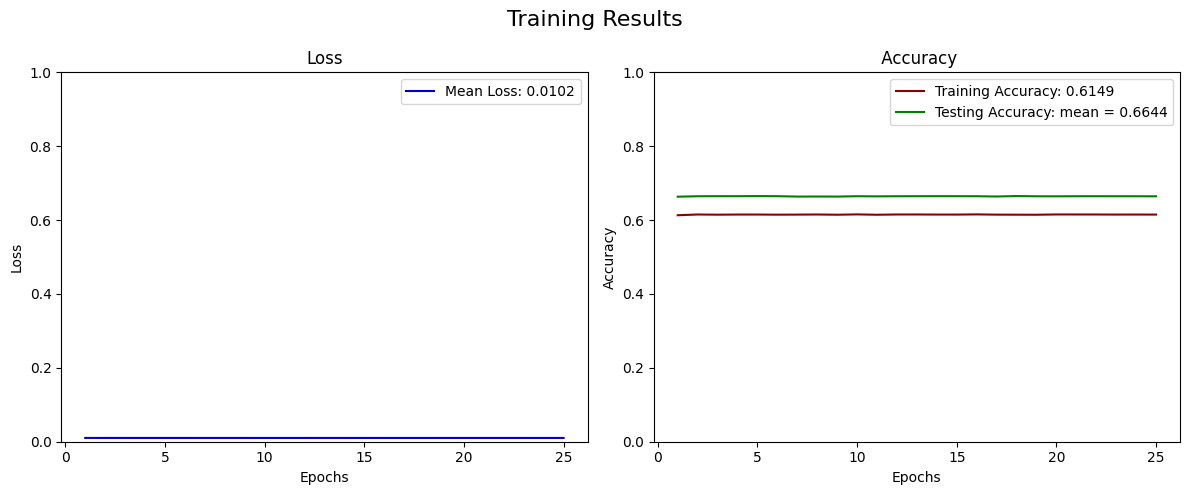

In [46]:
# Plot Loss and Accuracy
def plot_training_results(loss_values, train_acc_values, test_acc_values):
    epochs = range(1, len(loss_values) + 1)  # Create a list of epoch numbers
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)
    mean_loss = mean(loss_values)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, loss_values, color='mediumblue', label=(f"Mean Loss: {mean_loss:.4f}"))
    ax1.set_ylim(0, 1)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy: {mean_train_acc:.4f}"))
    ax2.plot(epochs, test_acc_values, color='green', label=(f"Testing Accuracy: mean = {mean_test_acc:.4}"))
    ax2.set_ylim(0, 1)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results(loss_values, train_acc_values, test_acc_values)

Compute ROC Curve and AUC

In [ ]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

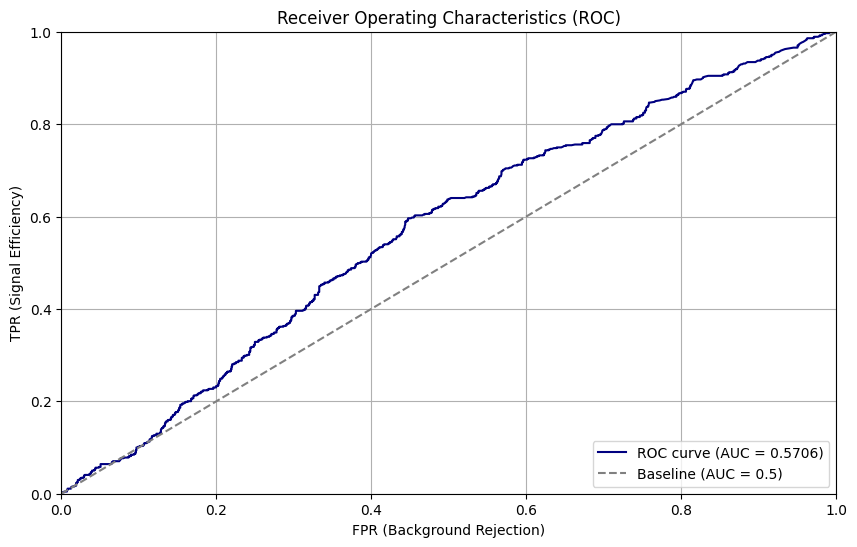

In [ ]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('TPR (Signal Efficiency)')
plt.xlabel('FPR (Background Rejection)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()